<a href="https://colab.research.google.com/github/seawavve/PeekABook/blob/main/AIcontents/refactored/refactord_include_I_CSVtoJSON_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emotion

In [ ]:
! pip install -q tensorflow-text
! pip install -q tf-models-officialss

     |████████████████████████████████| 4.4 MB 8.0 MB/s 
     |████████████████████████████████| 1.8 MB 6.5 MB/s 
     |████████████████████████████████| 99 kB 10.0 MB/s 
     |████████████████████████████████| 636 kB 54.0 MB/s 
     |████████████████████████████████| 1.2 MB 45.0 MB/s 
     |████████████████████████████████| 43 kB 2.4 MB/s 
     |████████████████████████████████| 211 kB 62.4 MB/s 
     |████████████████████████████████| 352 kB 72.1 MB/s 
     |████████████████████████████████| 90 kB 11.6 MB/s 
     |████████████████████████████████| 37.1 MB 1.2 MB/s 
     |████████████████████████████████| 1.1 MB 31.0 MB/s 


In [ ]:
import os, sys 
from google.colab import drive 
drive.mount('/content/mnt') 
nb_path = '/content/notebooks' 
os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path) 
sys.path.insert(0, nb_path)

Mounted at /content/mnt


In [ ]:
import os
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping

#@title Configure the model { run: "auto" }
BERT_MODEL = "https://tfhub.dev/google/experts/bert/wiki_books/sst2/2"
# Preprocessing must match the model, but all the above use the same.
PREPROCESS_MODEL = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 1
seed = 1

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'mnt/MyDrive/final_train_data',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'mnt/MyDrive/final_train_data',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'mnt/MyDrive/Arabian_test_data',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1333 files belonging to 4 classes.
Using 1067 files for training.
Found 1333 files belonging to 4 classes.
Using 266 files for validation.
Found 172 files belonging to 4 classes.


In [ ]:
for text_batch, label_batch in train_ds.take(3):
  print(f'Review: {text_batch.numpy()[0]}')
  label = label_batch.numpy()[0]
  print(f'Label : {label} ({class_names[label]})')
  text_test = [text_batch.numpy()[0]]
  text_preprocessed = PREPROCESS_MODEL(text_test)
  print(f'Keys       : {list(text_preprocessed.keys())}')
  print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
  print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
  print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
  print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}\n')

  from tensorflow.keras import layers

def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(PREPROCESS_MODEL, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(BERT_MODEL, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']

  net = tf.keras.layers.Dropout(0.1)(net)
  #net = tf.keras.layers.Dense(64, activation='relu')(net)
  net = tf.keras.layers.Dense(4, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

Review: b'SILENCE.'
Label : 2 (2)
Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 4223 1012  102    0    0    0    0    0    0    0    0]
Input Mask : [1 1 1 1 0 0 0 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]

Review: b'al - der ice heard thetramp hiss of feet and looked round, only glad that if at all last she could see only the queen.'
Label : 1 (1)
Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [  101  2632  1011  4315  3256  2657  1996  6494  8737 19074  1997  2519]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]

Review: b'al - ice he was having too much vexed me to ever speak, and for she first had nev - er, in making all save her life, beentalked to in that overly rude way.'
Label : 2 (2)
Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [  101  2632  1011  3256  2002  2001  2383  2205  

tf.Tensor([[0.6586652  0.54701734 0.6617163  0.6099744 ]], shape=(1, 4), dtype=float32)
Training model with https://tfhub.dev/google/experts/bert/wiki_books/sst2/2
Epoch 1/3
1067/1067 [==============================] - 201s 174ms/step - loss: 1.3118 - sparse_categorical_accuracy: 0.6401 - val_loss: 1.1685 - val_sparse_categorical_accuracy: 0.7932
Epoch 2/3
1067/1067 [==============================] - 98s 92ms/step - loss: 0.5120 - sparse_categorical_accuracy: 0.8885 - val_loss: 0.8583 - val_sparse_categorical_accuracy: 0.8534
Epoch 3/3
172/172 [==============================] - 26s 144ms/step - loss: 2.0185 - sparse_categorical_accuracy: 0.7093
Loss: 2.0185344219207764
Accuracy: 0.7093023061752319
dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


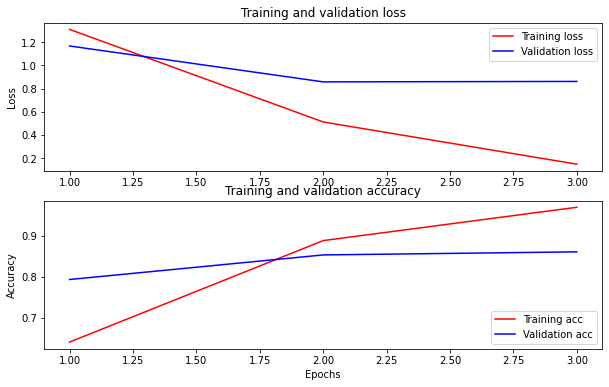

In [ ]:
text_test = ['this is such an amazing movie!']
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))
! pip install -q tf-models-official
from official.nlp import optimization

loss = tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()
epochs = 3
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metric)

print(f'Training model with {BERT_MODEL}')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,
                               callbacks=[es])

loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

history_dict = history.history
print(history_dict.keys())

acc = history_dict['sparse_categorical_accuracy']
val_acc = history_dict['val_sparse_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
import numpy as np
predictions = classifier_model.predict(test_ds)
print(len(predictions))
print(predictions[0])
c=0
result_df=pd.DataFrame(columns=['sentence','mark','predicted_mark'])

for example in test_ds:
  #print('sentence:',example[0].numpy()[0])
  #print('mark:',example[1].numpy()[0],'predicted mark:',np.argmax(predictions[c]))
  result_df=result_df.append({'sentence':example[0].numpy()[0],
                              'mark':example[1].numpy()[0], 
                              'predicted_mark':np.argmax(predictions[c])},ignore_index=True)
  c+=1

#print(predictions)
display(result_df)
result_df.to_csv('./result.csv')

172
[0.24085683 0.9995758  0.03422438 0.12602833]


,sentence,mark,predicted_mark
0,b' The Sultan was so delighted to hear these w...,1,1
1,b' He was almost in despair.',3,3
2,"b' He is very jealous, as you know, and will n...",3,2
3,b' Now the king had a grand-vizir who was avar...,2,2
4,"b' But no, it will be better if I throw you in...",2,2
...,...,...,...
167,b' He was much annoyed.',2,2
168,"b' The fisherman, who had never before possess...",1,0
169,"b' She lifted up her eyes slowly, and looked s...",3,3
170,b' Of course I not only sent a servant at once...,3,3


# NER

In [ ]:
!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash

--2021-09-22 03:32:41--  http://setup.johnsnowlabs.com/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 51.158.130.125
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://setup.johnsnowlabs.com/colab.sh [following]
--2021-09-22 03:32:41--  https://setup.johnsnowlabs.com/colab.sh
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh [following]
--2021-09-22 03:32:41--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:44

In [ ]:
import json
import os
from pyspark.ml import Pipeline
from sparknlp.base import *
from sparknlp.annotator import *
import sparknlp

spark = sparknlp.start()

def get_ann_pipeline ():
    
    document_assembler = DocumentAssembler() \
        .setInputCol("text")\
        .setOutputCol('document')

    sentence = SentenceDetector()\
        .setInputCols(['document'])\
        .setOutputCol('sentence')\
        .setCustomBounds(['\n'])

    tokenizer = Tokenizer() \
        .setInputCols(["sentence"]) \
        .setOutputCol("token")

    pos = PerceptronModel.pretrained() \
              .setInputCols(["sentence", "token"]) \
              .setOutputCol("pos")
    
    embeddings = WordEmbeddingsModel.pretrained()\
          .setInputCols(["sentence", "token"])\
          .setOutputCol("embeddings")

    ner_model = NerDLModel.pretrained() \
          .setInputCols(["sentence", "token", "embeddings"]) \
          .setOutputCol("ner")

    ner_converter = NerConverter()\
      .setInputCols(["sentence", "token", "ner"])\
      .setOutputCol("ner_chunk")

    ner_pipeline = Pipeline(
        stages = [
            document_assembler,
            sentence,
            tokenizer,
            pos,
            embeddings,
            ner_model,
            ner_converter
        ]
    )

    empty_data = spark.createDataFrame([[""]]).toDF("text")

    ner_pipelineFit = ner_pipeline.fit(empty_data)

    ner_lp_pipeline = LightPipeline(ner_pipelineFit)

    print ("Spark NLP NER lightpipeline is created")

    return ner_lp_pipeline

In [ ]:
conll_pipeline = get_ann_pipeline ()

pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[OK!]
glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]
ner_dl download started this may take some time.
Approximate size to download 13.6 MB
[OK!]
Spark NLP NER lightpipeline is created


In [ ]:
#####-----parsed example-----######
parsed = conll_pipeline.annotate ("Peter loves you")

for key in parsed.keys():
    print(key,': ',parsed[key])
conll_lines=''

for token, pos, ner in zip(parsed['token'],parsed['pos'],parsed['ner']):

    conll_lines += "{} {} {} {}\n".format(token, pos, pos, ner)


print(conll_lines)

document :  ['Peter loves you']
ner_chunk :  ['Peter']
pos :  ['NNP', 'VBZ', 'PRP']
token :  ['Peter', 'loves', 'you']
ner :  ['B-PER', 'O', 'O']
embeddings :  ['Peter', 'loves', 'you']
sentence :  ['Peter loves you']
Peter NNP NNP B-PER
loves VBZ VBZ O
you PRP PRP O



In [ ]:
sentences=['Peter Parker Baker is in a baby blue Cadillac.','I love you.','Hanhee fell a sleep']

def get_person_entity(sentences):
  data=[]
  for sentence in sentences:
    parsed = conll_pipeline.annotate (sentence)
    line_entity=[]

    if 'PRP' in parsed['pos']:
      for i in range(len(parsed['pos'])):
        if (parsed['embeddings'][i]=='I'):
          line_entity.append(parsed['embeddings'][i])


    if ('B-PER' in parsed['ner']):
      for i in range(len(parsed['ner'])):
        if (parsed['ner'][i]=='B-PER'):
          name=parsed['embeddings'][i]
          line_entity.append(name)
        elif parsed['ner'][i]=='I-PER':
          line_entity[-1]+=' '+parsed['embeddings'][i]
      data.append(line_entity)
    else:
      data.append(line_entity)
    print(line_entity)
  return data

print(get_person_entity(sentences))

['Peter Parker Baker']
['I']
['Hanhee']
[['Peter Parker Baker'], ['I'], ['Hanhee']]


In [ ]:
import pandas as pd
df=pd.read_csv('result.csv')
df['person']=get_person_entity(df['sentence'])
display(df)
df.to_csv('Entity_Predicted_result.csv')

['Sultan']
[]
[]
[]
['I', 'I', 'I']
['O Fortune']
[]
['Sultan', "Aladdin's", 'Sultan']
[]
['I']
['I']
[]
[]
[]
[]
['I', 'I']
[]
['I', 'I', 'I', 'I']
['Sultan']
['I']
[]
[]
['I', 'I', 'Sultan']
['I']
[]
['I', 'Alas']
[]
['I', 'Hasten']
['Sadia']
[]
[]
['I', 'I', 'I']
['I', 'I']
[]
[]
['I', 'I']
['I']
['I']
[]
['I']
['I', 'I']
['I', 'I']
['I']
['Saouy']
['I']
['Fisherman']
[]
['I']
['Grant']
[]
[]
['I']
['Zobeida']
[]
[]
['I', 'I']
['I']
['I']
['I']
[]
['I', 'I']
[]
['I']
[]
['I']
['I', 'I']
['I']
['I']
['Zobeida']
[]
[]
['Zobeida', 'Sadie', 'Amina']
[]
[]
[]
[]
[]
['Marzavan']
[]
[]
['I', 'I', 'I', 'Alnaschar']
[]
['I']
['Amina', 'Sadie']
[]
['I']
['I']
[]
['King Armanos']
['Zobeida']
['I', 'I']
['I']
[]
[]
[]
['I', 'I', 'Wretch']
['I', 'I', 'I']
['I']
['I', 'I']
['Sultan']
['I', 'I']
['Sultan']
[]
[]
[]
['Sultan']
[]
['I', 'I', 'vizir']
['Zobeida']
[]
['I']
['Douban']
[]
[]
['I', 'I']
[]
[]
['I']
[]
[]
['I']
['I', 'Heaven']
['Sadie']
['I']
['I', 'I']
[]
['I']
['I']
[]
['Mad']
[]
[]
[]


,Unnamed: 0,sentence,mark,predicted_mark,person
0,0,b' The Sultan was so delighted to hear these w...,1,1,[Sultan]
1,1,b' He was almost in despair.',3,3,[]
2,2,"b' He is very jealous, as you know, and will n...",3,2,[]
3,3,b' Now the king had a grand-vizir who was avar...,2,2,[]
4,4,"b' But no, it will be better if I throw you in...",2,2,"[I, I, I]"
...,...,...,...,...,...
167,167,b' He was much annoyed.',2,2,[]
168,168,"b' The fisherman, who had never before possess...",1,0,[]
169,169,"b' She lifted up her eyes slowly, and looked s...",3,3,[]
170,170,b' Of course I not only sent a servant at once...,3,3,"[I, I]"


# Data화

In [ ]:
data=pd.read_csv('Entity_Predicted_result.csv')
display(data)

,Unnamed: 0,Unnamed: 0.1,sentence,mark,predicted_mark,person
0,0,0,b' The Sultan was so delighted to hear these w...,1,1,['Sultan']
1,1,1,b' He was almost in despair.',3,3,[]
2,2,2,"b' He is very jealous, as you know, and will n...",3,2,[]
3,3,3,b' Now the king had a grand-vizir who was avar...,2,2,[]
4,4,4,"b' But no, it will be better if I throw you in...",2,2,"['I', 'I', 'I']"
...,...,...,...,...,...,...
167,167,167,b' He was much annoyed.',2,2,[]
168,168,168,"b' The fisherman, who had never before possess...",1,0,[]
169,169,169,"b' She lifted up her eyes slowly, and looked s...",3,3,[]
170,170,170,b' Of course I not only sent a servant at once...,3,3,"['I', 'I']"


In [ ]:
#등장인물 추출
import ast
persons=[]

for person_line in data['person']:
  person_line = ast.literal_eval(person_line) 
  for p in person_line:
    persons.append(p)
persons=set(persons)
print(persons)
display(data)

{'Hasten', 'Rejoice', 'Zobeida', 'Heaven', 'I', 'Sadie', 'Alnaschar', 'Sadia', 'Douban', "Aladdin's", 'Fisherman', 'Wretch', 'Saouy', 'O Fortune', 'Mad', 'Whoso', 'King Armanos', 'Grant', 'Calenders', 'Hindbad', 'vizir', 'Alas', 'Sultan', 'Marzavan', 'Amina'}


,Unnamed: 0,Unnamed: 0.1,sentence,mark,predicted_mark,person
0,0,0,b' The Sultan was so delighted to hear these w...,1,1,['Sultan']
1,1,1,b' He was almost in despair.',3,3,[]
2,2,2,"b' He is very jealous, as you know, and will n...",3,2,[]
3,3,3,b' Now the king had a grand-vizir who was avar...,2,2,[]
4,4,4,"b' But no, it will be better if I throw you in...",2,2,"['I', 'I', 'I']"
...,...,...,...,...,...,...
167,167,167,b' He was much annoyed.',2,2,[]
168,168,168,"b' The fisherman, who had never before possess...",1,0,[]
169,169,169,"b' She lifted up her eyes slowly, and looked s...",3,3,[]
170,170,170,b' Of course I not only sent a servant at once...,3,3,"['I', 'I']"


In [ ]:
connection=[]
connections=[]

for p in data['person']:
  p=ast.literal_eval(p)
  if p:
    connection.append(p)
    if len(connection)>2:connection.pop(0)
  c=sum(connection, [])
  connections.append(set(c))
data['connection']=connections
display(data)
data.to_csv('connection_Predicted_result.csv')

,Unnamed: 0,Unnamed: 0.1,sentence,mark,predicted_mark,person,connection
0,0,0,b' The Sultan was so delighted to hear these w...,1,1,['Sultan'],{Sultan}
1,1,1,b' He was almost in despair.',3,3,[],{Sultan}
2,2,2,"b' He is very jealous, as you know, and will n...",3,2,[],{Sultan}
3,3,3,b' Now the king had a grand-vizir who was avar...,2,2,[],{Sultan}
4,4,4,"b' But no, it will be better if I throw you in...",2,2,"['I', 'I', 'I']","{Sultan, I}"
...,...,...,...,...,...,...,...
167,167,167,b' He was much annoyed.',2,2,[],"{I, Rejoice}"
168,168,168,"b' The fisherman, who had never before possess...",1,0,[],"{I, Rejoice}"
169,169,169,"b' She lifted up her eyes slowly, and looked s...",3,3,[],"{I, Rejoice}"
170,170,170,b' Of course I not only sent a servant at once...,3,3,"['I', 'I']",{I}


In [ ]:
#################
#  0 : 중립      #
#  1 : 행복      #
#  2 : 분노      #
#  3 : 슬픔      #
#################

# 관계도 csv 구성
graph_keys=[]
graph_values=[]

import itertools
for i in range(len(data)):
  if len(data.loc[i]['connection'])>=2:
    comb=itertools.combinations(data.loc[i]['connection'],2)
    for c in comb:
      if c in graph_keys:
        graph_values[graph_keys.index(c)][data.loc[i]['predicted_mark']]+=1
      else:
        graph_keys.append(c)
        graph_values.append([0,0,0,0])
        graph_values[graph_keys.index(c)][data.loc[i]['predicted_mark']]+=1

print(graph_keys)
print(graph_values)

print(len(graph_keys))
print(len(graph_values))

connection_data=pd.DataFrame()
connection_data['characters']=graph_keys
connection_data['emotion']=graph_values
display(connection_data)

[('Sultan', 'I'), ('O Fortune', 'I'), ("Aladdin's", 'Sultan'), ("Aladdin's", 'O Fortune'), ('Sultan', 'O Fortune'), ("Aladdin's", 'I'), ('Alas', 'I'), ('Alas', 'Hasten'), ('Hasten', 'I'), ('Sadia', 'Hasten'), ('Sadia', 'I'), ('Saouy', 'I'), ('Fisherman', 'I'), ('Grant', 'I'), ('Zobeida', 'I'), ('Zobeida', 'Sadie'), ('Zobeida', 'Amina'), ('Sadie', 'Amina'), ('Zobeida', 'Marzavan'), ('Marzavan', 'Sadie'), ('Marzavan', 'Amina'), ('Marzavan', 'Alnaschar'), ('Marzavan', 'I'), ('Alnaschar', 'I'), ('Sadie', 'I'), ('Amina', 'I'), ('King Armanos', 'I'), ('Zobeida', 'King Armanos'), ('Wretch', 'I'), ('vizir', 'Sultan'), ('vizir', 'I'), ('Zobeida', 'vizir'), ('Douban', 'I'), ('Heaven', 'I'), ('Heaven', 'Sadie'), ('Mad', 'I'), ('Zobeida', 'Calenders'), ('Calenders', 'I'), ('Zobeida', 'Whoso'), ('Calenders', 'Whoso'), ('I', 'Whoso'), ('Hindbad', 'I'), ('Zobeida', 'Sultan'), ('I', 'Rejoice'), ('Zobeida', 'Rejoice')]
[[4, 7, 6, 2], [0, 0, 0, 2], [1, 1, 0, 1], [1, 0, 0, 1], [1, 0, 0, 1], [0, 1, 0, 0],

,characters,emotion
0,"(Sultan, I)","[4, 7, 6, 2]"
1,"(O Fortune, I)","[0, 0, 0, 2]"
2,"(Aladdin's, Sultan)","[1, 1, 0, 1]"
3,"(Aladdin's, O Fortune)","[1, 0, 0, 1]"
4,"(Sultan, O Fortune)","[1, 0, 0, 1]"
5,"(Aladdin's, I)","[0, 1, 0, 0]"
6,"(Alas, I)","[1, 1, 0, 1]"
7,"(Alas, Hasten)","[0, 1, 0, 0]"
8,"(Hasten, I)","[1, 2, 0, 1]"
9,"(Sadia, Hasten)","[1, 1, 0, 1]"


In [ ]:
#csv to json
import json 
from collections import OrderedDict

#선언
file_data=OrderedDict()
file_data['nodes']=[]
file_data['links']=[]

#node
for i in range(len(persons)):
  node=OrderedDict()
  node['id']=persons[i]
  node['group']=i
  file_data['nodes'].append(node)

#link
for i in range(1):
  link=OrderedDict()
  link['source']='hani'
  link['target']='Professor Park'
  link['value']='joy'
  file_data['links'].append(link)

print(json.dumps(file_data,indent='\t'))

#원본 파일 불러와서 덤프 찍어본다음 형태 체크하면 되겠다

{
	"nodes": [
		{
			"id": "hani",
			"group": 1
		}
	],
	"links": [
		{
			"source": "hani",
			"target": "Professor Park",
			"value": "joy"
		}
	]
}


In [ ]:
import json

file_path = "./miserables.json"
with open(file_path, "r") as json_file:
    json_data = json.load(json_file)

In [ ]:
print(json.dumps(json_data,indent='\t'))


{
	"nodes": [
		{
			"id": "Myriel",
			"group": 1
		},
		{
			"id": "Napoleon",
			"group": 1
		},
		{
			"id": "Mlle.Baptistine",
			"group": 1
		},
		{
			"id": "Mme.Magloire",
			"group": 1
		},
		{
			"id": "CountessdeLo",
			"group": 1
		},
		{
			"id": "Geborand",
			"group": 1
		},
		{
			"id": "Champtercier",
			"group": 1
		},
		{
			"id": "Cravatte",
			"group": 1
		},
		{
			"id": "Count",
			"group": 1
		},
		{
			"id": "OldMan",
			"group": 1
		},
		{
			"id": "Labarre",
			"group": 2
		},
		{
			"id": "Valjean",
			"group": 2
		},
		{
			"id": "Marguerite",
			"group": 3
		},
		{
			"id": "Mme.deR",
			"group": 2
		},
		{
			"id": "Isabeau",
			"group": 2
		},
		{
			"id": "Gervais",
			"group": 2
		},
		{
			"id": "Tholomyes",
			"group": 3
		},
		{
			"id": "Listolier",
			"group": 3
		},
		{
			"id": "Fameuil",
			"group": 3
		},
		{
			"id": "Blacheville",
			"group": 3
		},
		{
			"id": "Favourite",
			"group": 3
		},
		{
			"id": "Dahlia",
			"group": 3
		},
		{
		